In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import time, re, math, json
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed

# Optional: uncomment if you need to install packages
# %pip install geopy geopandas shapely pyproj --quiet

DATA = Path("/teamspace/studios/this_studio/data/dengue")
INTERIM = DATA/"interim"
FEATURES = DATA/"features"
REPORTS = DATA/"reports"
for p in [FEATURES, REPORTS]: p.mkdir(parents=True, exist_ok=True)

WEEKLY_FILE = INTERIM/"weekly_district_txt_filled_clean.parquet"   # from Step 1
assert WEEKLY_FILE.exists(), f"Missing {WEEKLY_FILE}"
wk = pd.read_parquet(WEEKLY_FILE).copy()

# เวลาใช้งาน
start_date = wk["week_start"].min().date().isoformat()
end_date   = wk["week_start"].max().date().isoformat()
print("Time span:", start_date, "→", end_date)
print("Series:", wk["district_id_txt_clean"].nunique(), "districts | rows:", len(wk))


Time span: 2018-01-01 → 2024-05-27
Series: 76 districts | rows: 21445


In [2]:
!pip install geopy geopandas

In [ ]:
manual_points = [
    ("คลองหลวง|ปทุมธานี", 14.065, 100.646),
    ("ค่ายบางระจัน|สิงห์บุรี", 14.800, 100.310),
    ("ชัยบาดาล|ลพบุรี", 15.206, 101.136),
    ("ดอนพุด|สระบุรี", 14.592, 100.628),
    ("ท่าช้าง|สิงห์บุรี", 14.761, 100.390),
    ("ท่าวุ้ง|ลพบุรี", 14.815, 100.511),
    ("ท่าหลวง|ลพบุรี", 15.068, 101.107),
    ("ท่าเรือ|พระนครศรีอยุธยา", 14.551, 100.727),
    ("ธัญบุรี|ปทุมธานี", 14.021, 100.734),
    ("นครหลวง|พระนครศรีอยุธยา", 14.464, 100.605),
    ("บางกรวย|นนทบุรี", 13.805, 100.472),
    ("บางซ้าย|พระนครศรีอยุธยา", 14.334, 100.850),
    ("บางบัวทอง|นนทบุรี", 13.968, 100.405),
    ("บางบาล|พระนครศรีอยุธยา", 14.373, 100.485),
    ("บางปะหัน|พระนครศรีอยุธยา", 14.462, 100.544),
    ("บางปะอิน|พระนครศรีอยุธยา", 14.227, 100.575),
    ("บางระจัน|สิงห์บุรี", 14.892, 100.317),
    ("บางใหญ่|นนทบุรี", 13.876, 100.403),
    # ("บางใหญ่|ปทุมธานี", None, None),  # ชื่อนี้ดูผิดจังหวัด — จะให้ geocode ตัดสิน
    ("บางไทร|พระนครศรีอยุธยา", 14.212, 100.498),
    ("บ้านนา|นครนายก", 14.266, 101.061),
    ("บ้านหมอ|สระบุรี", 14.599, 100.753),
    ("บ้านหมี่|ลพบุรี", 15.044, 100.537),
    ("บ้านแพรก|พระนครศรีอยุธยา", 14.647, 100.582),
    ("ปากพลี|นครนายก", 14.163, 101.268),
    ("ปากเกร็ด|นนทบุรี", 13.912, 100.498),
    ("ป่าโมก|อ่างทอง", 14.490, 100.448),
    ("ผักไห่|พระนครศรีอยุธยา", 14.458, 100.370),
    ("พรหมบุรี|สิงห์บุรี", 14.791, 100.453),
    ("พระนครศรีอยุธยา|พระนครศรีอยุธยา", 14.359, 100.584),
    ("พระพุทธบาท|สระบุรี", 14.727, 100.792),
    ("พัฒนานิคม|ลพบุรี", 14.855, 100.990),
    ("ภาชี|พระนครศรีอยุธยา", 14.449, 100.728),
    ("มวกเหล็ก|สระบุรี", 14.655, 101.198),
    ("มหาราช|พระนครศรีอยุธยา", 14.534, 100.527),
    ("ลาดบัวหลวง|พระนครศรีอยุธยา", 14.165, 100.307),
    ("ลาดหลุมแก้ว|ปทุมธานี", 14.037, 100.404),
    ("ลำลูกกา|ปทุมธานี", 13.932, 100.749),
    ("ลำสนธิ|ลพบุรี", 15.225, 101.287),
    ("วังน้อย|พระนครศรีอยุธยา", 14.226, 100.715),
    ("วังม่วง|สระบุรี", 14.845, 101.134),
    ("วิหารแดง|สระบุรี", 14.346, 100.989),
    ("วิเศษชัยชาญ|อ่างทอง", 14.595, 100.338),
    ("สระโบสถ์|ลพบุรี", 15.195, 100.848),
    ("สามโก้|อ่างทอง", 14.605, 100.244),
    ("สามโคก|ปทุมธานี", 14.065, 100.522),
    ("หนองม่วง|ลพบุรี", 15.247, 100.654),
    ("หนองเสือ|ปทุมธานี", 14.135, 100.824),
    ("หนองแค|สระบุรี", 14.339, 100.861),
    ("หนองแซง|สระบุรี", 14.492, 100.784),
    ("หนองโดน|สระบุรี", 14.681, 100.708),
    ("องครักษ์|นครนายก", 14.121, 101.004),
    ("อินทร์บุรี|สิงห์บุรี", 15.007, 100.327),
    ("อุทัย|พระนครศรีอยุธยา", 14.362, 100.670),
    ("เฉลิมพระเกียรติ|สระบุรี", 14.609, 100.905),
    ("เมืองนครนายก|นครนายก", 14.203, 101.217),
    ("เมืองนนทบุรี|นนทบุรี", 13.862, 100.513),
    ("เมืองปทุมธานี|ปทุมธานี", 14.019, 100.535),
    ("เมืองพระนครศรีอยุธยา|พระนครศรีอยุธยา", 14.359, 100.584),
    ("เมืองลพบุรี|ลพบุรี", 14.798, 100.653),
    ("เมืองสระบุรี|สระบุรี", 14.527, 100.909),
    ("เมืองสิงห์บุรี|สิงห์บุรี", 14.888, 100.404),
    ("เมืองอ่างทอง|อ่างทอง", 14.586, 100.450),
    ("เสนา|พระนครศรีอยุธยา", 14.327, 100.404),
    ("เสาไห้|สระบุรี", 14.550, 100.857),
    ("แก่งคอย|สระบุรี", 14.586, 100.998),
    ("แสวงหา|อ่างทอง", 14.756, 100.325),
    ("โคกสำโรง|ลพบุรี", 15.069, 100.724),
    ("โคกเจริญ|ลพบุรี", 15.382, 100.822),
    ("โพธิ์ทอง|อ่างทอง", 14.666, 100.408),
    ("ไชโย|อ่างทอง", 14.649, 100.478),
    ("ไทรน้อย|นนทบุรี", 13.979, 100.313),
]

coords = pd.DataFrame(manual_points, columns=["district_id_txt_clean","lat","lon"])

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

need = (wk[["district_id_txt_clean"]]
        .drop_duplicates().merge(coords, on="district_id_txt_clean", how="left"))
need_missing = need[need["lat"].isna()].copy()
print("Manual coords coverage:", len(coords), "rows")
print("Need geocoding for:", len(need_missing))

if len(need_missing):
    geolocator = Nominatim(user_agent="dengue-geocode")
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1.1)  # respect OSM usage policy

    lats, lons = [], []
    for name in need_missing["district_id_txt_clean"]:
        d, p = name.split("|", 1)
        query = f"{d}, จังหวัด{p}, ประเทศไทย"
        loc = geocode(query, addressdetails=True, language="th")
        if loc is None:
            # fallback: ไม่ใส่คำว่า จังหวัด
            loc = geocode(f"{d}, {p}, Thailand", addressdetails=True)
        if loc is None:
            lats.append(np.nan); lons.append(np.nan)
        else:
            lats.append(loc.latitude); lons.append(loc.longitude)
    need_missing["lat"] = lats; need_missing["lon"] = lons
    coords = pd.concat([coords, need_missing], ignore_index=True)

# 2.3 เก็บ cache
coords.drop_duplicates("district_id_txt_clean").to_csv(INTERIM/"district_coords.csv", index=False)
print("Saved coords:", INTERIM/"district_coords.csv")

# รวมเข้ากับ wk
wk = wk.merge(coords, on="district_id_txt_clean", how="left")
miss = wk["lat"].isna().mean()
print(f"WK rows missing coords: {miss:.1%}")
wk.head()


Manual coords coverage: 71 rows
Need geocoding for: 5
Saved coords: /teamspace/studios/this_studio/data/dengue/interim/district_coords.csv
WK rows missing coords: 0.2%


,week_start,cases,ipd_rate,fatal_rate,age_mean,dist_code4,province,district,district_id_txt,district_name_fix,province_name_fix,district_id_txt_clean,province_code,district_num,lat,lon
0,2020-03-23,1,0.0,0.0,36.000000,1212,นนทบุรี,1212,1212|นนทบุรี,1212,นนทบุรี,1212|นนทบุรี,2,1212,13.811061,100.505935
1,2019-10-28,1,0.0,0.0,54.971461,1326,ปทุมธานี,1326,1326|ปทุมธานี,1326,ปทุมธานี,1326|ปทุมธานี,3,1326,14.040277,100.413930
2,2022-11-07,1,0.0,0.0,39.893607,1341,ปทุมธานี,1341,1341|ปทุมธานี,1341,ปทุมธานี,1341|ปทุมธานี,3,1341,14.040277,100.413930
3,2023-04-03,1,0.0,0.0,19.129909,1312,ปทุมธานี,None,|ปทุมธานี,None,ปทุมธานี,None|ปทุมธานี,3,1312,NaN,NaN
4,2023-04-10,0,0.0,0.0,0.000000,1312,ปทุมธานี,None,|ปทุมธานี,None,ปทุมธานี,None|ปทุมธานี,3,1312,NaN,NaN


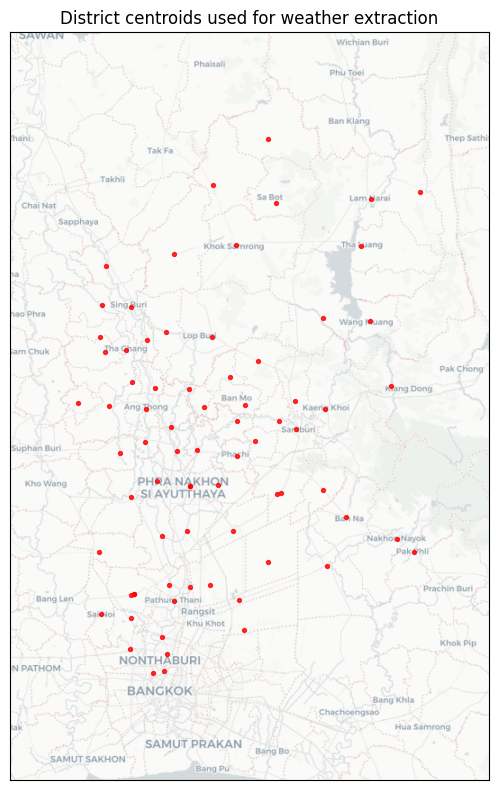

Saved: /teamspace/studios/this_studio/data/dengue/reports/district_coords_basemap.png


In [ ]:

# If these are not installed in your env, uncomment:
!pip -q install geopandas shapely pyproj contextily

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import contextily as cx
from pathlib import Path

INTERIM = Path("/teamspace/studios/this_studio/data/dengue/interim")
REPORTS = Path("/teamspace/studios/this_studio/data/dengue/reports")
REPORTS.mkdir(parents=True, exist_ok=True)

# Load coords (from Step 2-Cell 2)
coords_path = INTERIM / "district_coords.csv"
assert coords_path.exists(), f"Missing coords file: {coords_path}"
pts = pd.read_csv(coords_path)

# Clean + keep unique
pts = (pts
       .rename(columns={"district_id_txt_clean":"district"})
       .dropna(subset=["lat","lon"])
       .drop_duplicates(subset=["district"])
      )

# Make GeoDataFrame in EPSG:4326 -> to EPSG:3857 for web tiles
gdf = gpd.GeoDataFrame(
    pts,
    geometry=[Point(xy) for xy in zip(pts["lon"], pts["lat"])],
    crs="EPSG:4326"
).to_crs(epsg=3857)

# Compute nice extent (ODPC4 area roughly; padding by 5%)
xmin, ymin, xmax, ymax = gdf.total_bounds
pad_x = (xmax - xmin) * 0.2
pad_y = (ymax - ymin) * 0.2
extent = (xmin - pad_x, xmax + pad_x, ymin - pad_y, ymax + pad_y)

fig, ax = plt.subplots(figsize=(6.5, 8))

# Plot points first (so basemap will go under after add_basemap)
gdf.plot(ax=ax, markersize=8, color="red", alpha=0.8)

# Basemap: CartoDB.Positron (clean grayscale)
# If it fails (e.g., no internet), we fall back to plain scatter
added = False
try:
    cx.add_basemap(
        ax,
        crs=gdf.crs.to_string(),
        source=cx.providers.CartoDB.Positron,
        attribution="",   # keep plot clean
    )
    added = True
except Exception as e:
    print("[WARN] Basemap tiles not loaded:", e)

# Apply extent and cosmetics
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.set_title("District centroids used for weather extraction", fontsize=12)
ax.set_xlabel("Web Mercator X")
ax.set_ylabel("Web Mercator Y")
ax.grid(True, alpha=0.15)

# Hide axis labels if basemap is present (clean look)
if added:
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])

out_png = REPORTS / "district_coords_basemap.png"
plt.tight_layout()
plt.savefig(out_png, dpi=180)
plt.show()
print("Saved:", out_png)


In [ ]:

# !pip -q install tqdm  # ถ้ายังไม่มี tqdm ให้เปิดคอมเมนต์บรรทัดนี้

import os, time, json, math, re
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import requests
from tqdm.auto import tqdm

DATA = Path("/teamspace/studios/this_studio/data/dengue")
INTERIM = DATA/"interim"
FEATURES = DATA/"features"
REPORTS = DATA/"reports"
for p in [FEATURES, REPORTS]: p.mkdir(parents=True, exist_ok=True)

# === โหลดชุด weekly + coords (จาก Step 1/2) ===
wk = pd.read_parquet(INTERIM/"weekly_district_txt_filled_clean.parquet").copy()
coords = pd.read_csv(INTERIM/"district_coords.csv")

# จำกัดเฉพาะอำเภอที่มี lat/lon
districts = (wk[["district_id_txt_clean"]]
             .drop_duplicates()
             .merge(coords, on="district_id_txt_clean", how="left")
             .dropna(subset=["lat","lon"]))

start_date = wk["week_start"].min().date().isoformat()
end_date   = wk["week_start"].max().date().isoformat()
print(f"Time span: {start_date} → {end_date}")
print("Unique districts with coords:", len(districts))

# === แหล่งข้อมูล + พารามิเตอร์ ===
ERA_BASE   = "https://archive-api.open-meteo.com/v1/era5"
TIMEZONE   = "Asia/Bangkok"
DAILY_VARS = [
    "temperature_2m_mean","temperature_2m_min","temperature_2m_max",
    "relative_humidity_2m_mean","dewpoint_2m_mean",
    "precipitation_sum","rain_sum",
    "shortwave_radiation_sum","windspeed_10m_max",
]

POWER_BASE   = "https://power.larc.nasa.gov/api/temporal/daily/point"
POWER_PARAMS = ["T2M","T2M_MIN","T2M_MAX","RH2M","PRECTOTCORR","ALLSKY_SFC_SW_DWN","WS10M"]

# คุมความถี่ในการยิง API (ต่อเขต)
REQUEST_GAP_SEC = 1.2   # ปรับได้ 1.2–1.5 จะปลอดภัยกับ ERA5

# รีซูมงานได้: ไม่บังคับดึงใหม่ถ้ามี cache แล้ว
force_refresh = False

# === HTTP session ===
SESSION = requests.Session()
SESSION.headers.update({"User-Agent": "odpc4-dengue-weather/1.0"})

def safe_sleep(sec):
    try:
        time.sleep(sec)
    except KeyboardInterrupt:
        raise

def dewpoint_from_t_rh(t_c, rh):
    """คำนวณจุดน้ำค้างจากอุณหภูมิ (°C) และ RH (%) ด้วย Magnus approximation"""
    a, b = 17.625, 243.04
    rh = np.clip(pd.to_numeric(rh, errors="coerce").fillna(0), 0.1, 100.0)  # หลีกเลี่ยง log(0)
    t  = pd.to_numeric(t_c, errors="coerce").fillna(np.nan)
    alpha = np.log(rh/100.0) + (a*t)/(b + t)
    return (b*alpha)/(a - alpha)

def era5_fetch(did, lat, lon, start_date, end_date, max_retries=6):
    """เรียก ERA5 (Open-Meteo) พร้อม backoff และเคารพ Retry-After; คืน DataFrame รายวัน"""
    params = {
        "latitude": float(lat),
        "longitude": float(lon),
        "start_date": start_date,
        "end_date": end_date,
        "daily": ",".join(DAILY_VARS),
        "timezone": TIMEZONE,
    }
    last_err = None
    for attempt in range(max_retries):
        r = SESSION.get(ERA_BASE, params=params, timeout=60)
        if r.status_code == 429:
            ra = r.headers.get("Retry-After")
            wait = float(ra) if ra else max(3.0, 2.0**attempt)
            safe_sleep(wait)
            continue
        try:
            r.raise_for_status()
            d = r.json().get("daily", {})
            df = pd.DataFrame(d)
            if "time" not in df.columns or len(df) == 0:
                raise ValueError("ERA5 response empty/malformed")
            df = df.rename(columns={"time":"date"})
            df["date"] = pd.to_datetime(df["date"])
            df["district_id_txt_clean"] = did
            df["source"] = "ERA5"
            return df
        except Exception as e:
            last_err = e
            safe_sleep(max(3.0, 2.0**attempt))
    raise last_err

def nasa_power_fetch(did, lat, lon, start_date, end_date, max_retries=6):
    """Fallback NASA POWER → map เป็น schema เดียวกับ ERA5 เท่าที่ทำได้"""
    params = {
        "parameters": ",".join(POWER_PARAMS),
        "start": start_date.replace("-",""),
        "end":   end_date.replace("-",""),
        "latitude": float(lat),
        "longitude": float(lon),
        "community": "AG",
        "format": "JSON",
        "time-standard": "UTC",
    }
    last_err = None
    for attempt in range(max_retries):
        r = SESSION.get(POWER_BASE, params=params, timeout=60)
        if r.status_code == 429:
            ra = r.headers.get("Retry-After")
            wait = float(ra) if ra else max(3.0, 2.0**attempt)
            safe_sleep(wait); continue
        try:
            r.raise_for_status()
            js = r.json()
            param = js.get("properties", {}).get("parameter", {})
            if not param:
                raise ValueError("POWER response empty")
            dates = sorted(set().union(*[set(v.keys()) for v in param.values()]))
            df = pd.DataFrame({"date": pd.to_datetime(dates)})
            def pick(name):
                m = param.get(name, {})
                return df["date"].dt.strftime("%Y%m%d").map(m.get)
            # map เป็นคอลัมน์ใกล้เคียง
            df["temperature_2m_mean"] = pick("T2M")
            df["temperature_2m_min"]  = pick("T2M_MIN")
            df["temperature_2m_max"]  = pick("T2M_MAX")
            df["relative_humidity_2m_mean"] = pick("RH2M")
            df["dewpoint_2m_mean"] = dewpoint_from_t_rh(df["temperature_2m_mean"], df["relative_humidity_2m_mean"])
            df["precipitation_sum"] = pick("PRECTOTCORR")        # mm/day
            df["rain_sum"]          = df["precipitation_sum"]    # approx
            df["shortwave_radiation_sum"] = pick("ALLSKY_SFC_SW_DWN")  # kWh/m²/day (หน่วยต่างจาก ERA5)
            df["windspeed_10m_max"] = pick("WS10M")              # ใช้ mean แทน max
            df["district_id_txt_clean"] = did
            df["source"] = "POWER"
            return df
        except Exception as e:
            last_err = e
            safe_sleep(max(3.0, 2.0**attempt))
    raise last_err

def cache_path_for(did): return FEATURES/f"weather_daily__{did}.csv"
def load_cache(did):
    f = cache_path_for(did)
    if f.exists():
        return pd.read_csv(f, parse_dates=["date"])
    return None
def save_cache(did, df):
    f = cache_path_for(did)
    df.to_csv(f, index=False)

# === โหลดจาก cache ล่วงหน้า (resume) ===
cached = []
for did in districts["district_id_txt_clean"]:
    c = load_cache(did)
    if (c is not None) and (not force_refresh):
        cached.append(did)
print("Cached districts:", len(cached))

need_fetch = districts[~districts["district_id_txt_clean"].isin(cached)].copy()
print("Need to fetch:", len(need_fetch))

log_file = FEATURES/"weather_fetch_log.csv"
if not log_file.exists():
    pd.DataFrame(columns=["district","source","status","n_rows","started_at","ended_at","error"]).to_csv(log_file, index=False)

succ_era, succ_power, fail_cnt, cached_cnt = 0, 0, 0, len(cached)

# === ดึงแบบต่อคิว + progress bar ===
pbar = tqdm(total=len(districts), desc="Fetching daily weather", unit="district")
pbar.update(cached_cnt)  # นับ cache ที่มีอยู่เป็น progress แล้ว

for _, row in need_fetch.iterrows():
    did, lat, lon = row["district_id_txt_clean"], float(row["lat"]), float(row["lon"])
    started = datetime.now()
    status  = "OK"
    source  = ""
    n_rows  = 0
    err_msg = ""

    try:
        # 1) พยายาม ERA5 ก่อน
        df = era5_fetch(did, lat, lon, start_date, end_date)
        source = "ERA5"
        n_rows = len(df)
        save_cache(did, df)
        succ_era += 1
    except Exception as e1:
        try:
            # 2) fallback NASA POWER
            df = nasa_power_fetch(did, lat, lon, start_date, end_date)
            source = "POWER"
            n_rows = len(df)
            save_cache(did, df)
            succ_power += 1
        except Exception as e2:
            status = "FAIL"
            err_msg = f"ERA5:{str(e1)} | POWER:{str(e2)}"
            fail_cnt += 1

    ended = datetime.now()
    # append log
    pd.DataFrame([{
        "district": did, "source": source, "status": status, "n_rows": n_rows,
        "started_at": started.isoformat(timespec="seconds"),
        "ended_at":   ended.isoformat(timespec="seconds"),
        "error": err_msg[:500]
    }]).to_csv(log_file, mode="a", header=False, index=False)

    # progress UI
    pbar.set_postfix({
        "ERA5": succ_era,
        "POWER": succ_power,
        "FAIL": fail_cnt,
        "Last": f"{did} ({source or '—'})"
    })
    pbar.update(1)
    safe_sleep(REQUEST_GAP_SEC)

pbar.close()
print(f"Done. ERA5:{succ_era} | POWER:{succ_power} | FAIL:{fail_cnt} | CACHED:{cached_cnt}")
print("Log:", log_file)

# === รวมทั้งหมดจาก cache ให้เป็น weather_daily ===
daily_frames = []
for did in districts["district_id_txt_clean"].unique():
    df = load_cache(did)
    if df is None:
        continue
    # ให้แน่ใจว่าคอลัมน์ครบตาม schema
    for c in ["date","district_id_txt_clean","source"] + DAILY_VARS:
        if c not in df.columns:
            df[c] = np.nan
    df["date"] = pd.to_datetime(df["date"])
    df["district_id_txt_clean"] = did
    daily_frames.append(df[["district_id_txt_clean","date"] + DAILY_VARS + ["source"]])

weather_daily = (pd.concat(daily_frames, ignore_index=True)
                   .sort_values(["district_id_txt_clean","date"])
                   .reset_index(drop=True))
print("weather_daily shape:", weather_daily.shape)
display(weather_daily.head(3))

# รายงานอำเภอที่ยังขาดหมด (ถ้ามี)
missing_any = weather_daily.groupby("district_id_txt_clean")[DAILY_VARS].apply(lambda d: d.isna().all().any())
if missing_any.any():
    print("Districts that still miss any variable entirely:")
    display(pd.DataFrame(missing_any[missing_any].index, columns=["district_id_txt_clean"]))
else:
    print("All districts have data columns present (some values may still be NaN at edges).")


Time span: 2018-01-01 → 2024-05-27
Unique districts with coords: 75
Cached districts: 46
Need to fetch: 29


Fetching daily weather:   0%|          | 0/75 [00:00<?, ?district/s]

Done. ERA5:19 | POWER:10 | FAIL:0 | CACHED:46
Log: /teamspace/studios/this_studio/data/dengue/features/weather_fetch_log.csv
weather_daily shape: (175425, 12)


,district_id_txt_clean,date,temperature_2m_mean,temperature_2m_min,temperature_2m_max,relative_humidity_2m_mean,dewpoint_2m_mean,precipitation_sum,rain_sum,shortwave_radiation_sum,windspeed_10m_max,source
0,1212|นนทบุรี,2018-01-01,24.2,20.0,28.5,73.0,18.9,0.0,0.0,17.42,10.7,ERA5
1,1212|นนทบุรี,2018-01-02,24.6,20.3,29.3,74.0,19.4,0.0,0.0,19.07,12.2,ERA5
2,1212|นนทบุรี,2018-01-03,25.6,21.9,29.8,72.0,20.0,0.0,0.0,15.32,9.5,ERA5


All districts have data columns present (some values may still be NaN at edges).


In [ ]:

import numpy as np
import pandas as pd
from pathlib import Path

DATA = Path("/teamspace/studios/this_studio/data/dengue")
FEATURES = DATA/"features"

# ถ้ายังมีตัวแปร weather_daily อยู่แล้วก็ใช้เลย; ถ้าไม่มี ให้รวมจาก cache CSV
if "weather_daily" not in globals():
    daily_frames = []
    for f in sorted(FEATURES.glob("weather_daily__*.csv")):
        df = pd.read_csv(f, parse_dates=["date"])
        daily_frames.append(df)
    weather_daily = pd.concat(daily_frames, ignore_index=True).sort_values(["district_id_txt_clean","date"])

print("weather_daily shape:", weather_daily.shape)
print("sources:", weather_daily["source"].value_counts().to_dict())

# ช่วงวัน และจำนวนวันที่คาดหวัง
start_date = weather_daily["date"].min().date()
end_date   = weather_daily["date"].max().date()
exp_days   = pd.date_range(start_date, end_date, freq="D").size
print(f"Span: {start_date} → {end_date} | expected days per district: {exp_days}")

# ต่ออำเภอควรมี exp_days แถว
cnt_by_dist = weather_daily.groupby("district_id_txt_clean")["date"].count().sort_values()
bad_len = cnt_by_dist[cnt_by_dist != exp_days]
print("Districts with incomplete rows:", int((cnt_by_dist != exp_days).sum()))
if not bad_len.empty:
    display(bad_len.head())

# เช็ค duplicates (district, date)
dup_mask = weather_daily.duplicated(subset=["district_id_txt_clean","date"], keep=False)
print("Exact duplicates:", dup_mask.sum())

# ดูช่วงค่าเบื้องต้น
cols = ["temperature_2m_mean","temperature_2m_min","temperature_2m_max",
        "relative_humidity_2m_mean","dewpoint_2m_mean",
        "precipitation_sum","rain_sum",
        "shortwave_radiation_sum","windspeed_10m_max"]
desc = weather_daily[cols].describe(percentiles=[.01,.05,.5,.95,.99])
display(desc)

# เช็คค่าติดลบที่ไม่ควรติดลบ
for c in ["precipitation_sum","rain_sum","shortwave_radiation_sum","windspeed_10m_max"]:
    neg = (pd.to_numeric(weather_daily[c], errors="coerce") < 0).sum()
    print(f"Negative {c}: {neg}")


weather_daily shape: (175425, 12)
sources: {'ERA5': 114611, 'POWER': 51458}
Span: 2018-01-01 → 2024-05-27 | expected days per district: 2339
Districts with incomplete rows: 0
Exact duplicates: 0


,temperature_2m_mean,temperature_2m_min,temperature_2m_max,relative_humidity_2m_mean,dewpoint_2m_mean,precipitation_sum,rain_sum,shortwave_radiation_sum,windspeed_10m_max
count,175425.000000,175425.000000,175425.000000,175425.000000,175425.000000,175425.000000,175425.000000,175425.000000,175425.000000
mean,27.976715,24.102779,32.787202,72.448080,22.110270,4.224234,4.224234,18.450687,11.408063
std,2.313676,2.407445,2.983663,11.614317,3.114010,7.486890,7.486890,3.722536,6.580809
min,15.080000,10.100000,20.920000,30.840000,5.400000,0.000000,0.000000,2.720000,0.350000
1%,21.500000,16.300000,26.022400,45.980000,12.179461,0.000000,0.000000,6.890000,1.290000
5%,24.060000,19.230000,28.210000,52.000000,15.400000,0.000000,0.000000,11.250000,1.920000
50%,27.970000,24.500000,32.500000,74.000000,23.300000,0.700000,0.700000,18.970000,12.300000
95%,31.900000,27.300000,38.130000,88.880000,25.100000,19.200000,19.200000,23.660000,21.400000
99%,33.600000,28.570000,40.850000,92.000000,25.555370,34.100000,34.100000,25.020000,25.200000
max,37.790000,31.000000,45.840000,96.440000,26.700000,182.800000,182.800000,26.660000,43.900000


Negative precipitation_sum: 0
Negative rain_sum: 0
Negative shortwave_radiation_sum: 0
Negative windspeed_10m_max: 0


In [ ]:

import numpy as np
import pandas as pd
from pathlib import Path

DATA = Path("/teamspace/studios/this_studio/data/dengue")
FEATURES = DATA/"features"
FEATURES.mkdir(parents=True, exist_ok=True)

wd = weather_daily.copy()

# 1) แปลงหน่วย shortwave ของ POWER: kWh/m²/day -> MJ/m²/day
mask_power = wd["source"].eq("POWER")
wd.loc[mask_power, "shortwave_radiation_sum"] = (
    pd.to_numeric(wd.loc[mask_power, "shortwave_radiation_sum"], errors="coerce") * 3.6
)

# 2) Clip ค่าไม่สมเหตุผล
wd["relative_humidity_2m_mean"] = pd.to_numeric(wd["relative_humidity_2m_mean"], errors="coerce").clip(0, 100)
for c in ["precipitation_sum","rain_sum"]:
    wd[c] = pd.to_numeric(wd[c], errors="coerce").clip(lower=0)

# wind/radiation/temperature: ไม่ clip แน่นเพื่อรักษาสัญญาณ outlier แต่คุณจะ flag ได้
wd["windspeed_10m_max"] = pd.to_numeric(wd["windspeed_10m_max"], errors="coerce")
wd["shortwave_radiation_sum"] = pd.to_numeric(wd["shortwave_radiation_sum"], errors="coerce")
for c in ["temperature_2m_mean","temperature_2m_min","temperature_2m_max","dewpoint_2m_mean"]:
    wd[c] = pd.to_numeric(wd[c], errors="coerce")

# 3) ฟีเจอร์เสริม: VPD (kPa) จาก Tmean & RH
T = wd["temperature_2m_mean"]
RH = wd["relative_humidity_2m_mean"]
es_kpa = 0.6108 * np.exp((17.27 * T) / (T + 237.3))     # saturation vapor pressure
wd["vpd_kpa"] = es_kpa * (1 - RH/100.0)

# 4) บันทึกเป็น daily harmonized
out_daily = FEATURES/"weather_daily_harmonized.parquet"
wd.to_parquet(out_daily, index=False)
print("Saved:", out_daily)

# 5) แสดงสรุปเล็ก ๆ แยกตาม source เพื่อตรวจว่า distribution ดูไม่หลุดโลก
summary_by_source = (wd
    .groupby("source")[["temperature_2m_mean","relative_humidity_2m_mean",
                        "precipitation_sum","shortwave_radiation_sum",
                        "windspeed_10m_max","vpd_kpa"]]
    .agg(["mean","std","min","max"]))
display(summary_by_source)


Saved: /teamspace/studios/this_studio/data/dengue/features/weather_daily_harmonized.parquet


temperature_2m_mean                         relative_humidity_2m_mean  \
                      mean       std    min    max                      mean   
source                                                                         
ERA5             28.049823  2.054006  17.60  35.60                 71.842101   
POWER            27.790153  2.824462  15.08  37.79                 73.947907   

                                precipitation_sum            ...  \
              std    min    max              mean       std  ...   
source                                                       ...   
ERA5    11.254447  35.00  96.00          4.420660  7.722782  ...   
POWER   12.353307  30.84  96.44          3.786309  6.885867  ...   

       shortwave_radiation_sum         windspeed_10m_max                  \
                           min     max              mean       std   min   
source                                                                     
ERA5                     2.910  26.380         14.931142  4.303835  4.80   
POWER                    9.792  95.976          2.906632  0.987182  0.35   

                vpd_kpa                                
          max      mean       std       min       max  
source                                                 
ERA5    43.90  1.082271  0.462109  0.121523  3.138396  
POWER    8.35  1.025470  0.619135  0.101784  4.062443  

[2 rows x 24 columns]

In [ ]:

import pandas as pd
from pathlib import Path

DATA = Path("/teamspace/studios/this_studio/data/dengue")
FEATURES = DATA/"features"
INTERIM  = DATA/"interim"

wd = pd.read_parquet(FEATURES/"weather_daily_harmonized.parquet")
wd["week_start"] = wd["date"] - pd.to_timedelta(wd["date"].dt.weekday, unit="D")

agg_map = {
    "temperature_2m_mean": "mean",
    "temperature_2m_min": "mean",
    "temperature_2m_max": "mean",
    "relative_humidity_2m_mean": "mean",
    "dewpoint_2m_mean": "mean",
    "vpd_kpa": "mean",
    "windspeed_10m_max": "mean",              # หมายเหตุ: ERA5 = max, POWER = mean → ให้โมเดลเรียนรู้จาก source ได้
    "precipitation_sum": "sum",
    "rain_sum": "sum",
    "shortwave_radiation_sum": "sum",         # เป็น MJ/m² ต่อสัปดาห์ หลัง harmonize
}

weather_weekly = (wd
    .groupby(["district_id_txt_clean","week_start"], as_index=False)
    .agg(agg_map))

out_weekly = FEATURES/"weather_weekly_features.parquet"
weather_weekly.to_parquet(out_weekly, index=False)
print("Saved:", out_weekly)
display(weather_weekly.head(10))
print("Rows:", len(weather_weekly), "| districts:", weather_weekly["district_id_txt_clean"].nunique())


Saved: /teamspace/studios/this_studio/data/dengue/features/weather_weekly_features.parquet


,district_id_txt_clean,week_start,temperature_2m_mean,temperature_2m_min,temperature_2m_max,relative_humidity_2m_mean,dewpoint_2m_mean,vpd_kpa,windspeed_10m_max,precipitation_sum,rain_sum,shortwave_radiation_sum
0,1212|นนทบุรี,2018-01-01,25.885714,22.242857,29.957143,75.571429,21.042857,0.813395,11.157143,11.5,11.5,116.14
1,1212|นนทบุรี,2018-01-08,23.485714,20.700000,26.942857,78.428571,19.314286,0.607195,13.385714,50.8,50.8,96.26
2,1212|นนทบุรี,2018-01-15,25.800000,21.057143,30.442857,70.428571,19.742857,0.986560,10.157143,0.0,0.0,124.23
3,1212|นนทบุรี,2018-01-22,27.100000,24.271429,30.614286,82.285714,23.614286,0.637451,11.114286,19.3,19.3,102.36
4,1212|นนทบุรี,2018-01-29,25.414286,22.985714,28.314286,77.000000,20.871429,0.725132,15.685714,12.6,12.6,87.52
5,1212|นนทบุรี,2018-02-05,24.400000,20.171429,29.028571,72.714286,18.785714,0.817250,13.600000,1.6,1.6,126.67
6,1212|นนทบุรี,2018-02-12,26.728571,21.942857,32.028571,71.857143,20.700000,0.978952,13.885714,0.4,0.4,144.87
7,1212|นนทบุรี,2018-02-19,27.185714,24.185714,31.114286,81.714286,23.571429,0.663697,12.285714,49.2,49.2,120.94
8,1212|นนทบุรี,2018-02-26,27.742857,24.457143,31.757143,80.428571,23.842857,0.731943,13.614286,16.5,16.5,132.99
9,1212|นนทบุรี,2018-03-05,27.357143,24.114286,31.357143,77.714286,22.857143,0.806782,13.085714,31.5,31.5,120.13


Rows: 25125 | districts: 75


In [6]:
weather_daily

,district_id_txt_clean,date,temperature_2m_mean,temperature_2m_min,temperature_2m_max,relative_humidity_2m_mean,dewpoint_2m_mean,precipitation_sum,rain_sum,shortwave_radiation_sum,windspeed_10m_max,source
0,1212|นนทบุรี,2018-01-01,24.2,20.0,28.5,73.0,18.9,0.0,0.0,17.42,10.7,ERA5
1,1212|นนทบุรี,2018-01-02,24.6,20.3,29.3,74.0,19.4,0.0,0.0,19.07,12.2,ERA5
2,1212|นนทบุรี,2018-01-03,25.6,21.9,29.8,72.0,20.0,0.0,0.0,15.32,9.5,ERA5
3,1212|นนทบุรี,2018-01-04,26.3,22.1,30.5,72.0,20.6,0.0,0.0,17.84,10.2,ERA5
4,1212|นนทบุรี,2018-01-05,27.2,23.6,31.2,73.0,21.7,0.1,0.1,15.60,8.4,ERA5
...,...,...,...,...,...,...,...,...,...,...,...,...
175420,ไทรน้อย|นนทบุรี,2024-05-23,27.9,25.8,31.1,87.0,25.5,9.9,9.9,14.03,15.0,ERA5
175421,ไทรน้อย|นนทบุรี,2024-05-24,28.0,26.2,30.2,85.0,25.2,4.7,4.7,10.63,14.9,ERA5
175422,ไทรน้อย|นนทบุรี,2024-05-25,28.8,26.6,33.4,82.0,25.3,4.5,4.5,18.70,15.0,ERA5
175423,ไทรน้อย|นนทบุรี,2024-05-26,29.0,26.4,33.3,82.0,25.4,9.8,9.8,20.82,21.9,ERA5


In [ ]:

import pandas as pd
import numpy as np
from pathlib import Path

DATA = Path("/teamspace/studios/this_studio/data/dengue")
INTERIM = DATA/"interim"
FEATURES = DATA/"features"
REPORTS = DATA/"reports"
MODELS = DATA/"models"
for p in [FEATURES, REPORTS, MODELS]: p.mkdir(parents=True, exist_ok=True)

# --- Load weekly cases (clean) & weekly weather features (from Cell 4.3)
cases_wk = pd.read_parquet(INTERIM/"weekly_district_txt_filled_clean.parquet")
wx_wk    = pd.read_parquet(FEATURES/"weather_weekly_features.parquet")

# Keep only needed columns from cases
cases_wk = cases_wk[[
    "district_id_txt_clean","week_start","cases","ipd_rate","fatal_rate","age_mean",
    # ถ้าไฟล์ของคุณมี mapping เหล่านี้จะใช้เลย; ถ้าไม่มีโค้ดด้านล่างจะสร้างตัวเลขแทน
    *(c for c in ["district_num","province_code","dist_code4","province_name_fix","district_name_fix"] if c in cases_wk.columns)
]].copy()

# Ensure weekly anchor is Monday (consistent with wx_wk)
cases_wk["week_start"] = pd.to_datetime(cases_wk["week_start"]) - pd.to_timedelta(
    pd.to_datetime(cases_wk["week_start"]).dt.weekday, unit="D"
)
wx_wk["week_start"] = pd.to_datetime(wx_wk["week_start"])

# Merge (left=cases soเราพยากรณ์ cases; ฟีเจอร์อากาศเป็น independent vars)
df = cases_wk.merge(
    wx_wk,
    on=["district_id_txt_clean","week_start"],
    how="left",
    validate="m:1"
)

# Fill NA reasonable defaults (เฉพาะฟีเจอร์ exogenous)
for c in ["precipitation_sum","rain_sum","shortwave_radiation_sum"]:
    if c in df.columns:
        df[c] = df[c].fillna(0.0)
for c in ["temperature_2m_mean","temperature_2m_min","temperature_2m_max",
          "relative_humidity_2m_mean","dewpoint_2m_mean","vpd_kpa",
          "windspeed_10m_max","age_mean"]:
    if c in df.columns:
        df[c] = df[c].astype(float).fillna(df[c].median())

# Create numeric IDs for plots (English-friendly) if not present
if "district_num" not in df.columns:
    # stable coding by sorted unique name
    dmap = {k:i for i,k in enumerate(sorted(df["district_id_txt_clean"].unique()), start=1)}
    df["district_num"] = df["district_id_txt_clean"].map(dmap)
if "province_code" not in df.columns:
    # naive province code by order
    pmap = {k:i for i,k in enumerate(sorted(df["district_id_txt_clean"].str.split("|").str[-1].unique()), start=1)}
    df["province_code"] = df["district_id_txt_clean"].str.split("|").str[-1].map(pmap)

# Seasonality features (English-only names)
dt = pd.to_datetime(df["week_start"])
df["year"]        = dt.dt.year
df["weekofyear"]  = dt.dt.isocalendar().week.astype(int)
df["month"]       = dt.dt.month
# cyclical encodings
df["sin_woy"] = np.sin(2*np.pi*df["weekofyear"]/52.0)
df["cos_woy"] = np.cos(2*np.pi*df["weekofyear"]/52.0)

# Safe lag/rolling per district (no leakage)
def add_lags_rolls(g, cols_lag, cols_roll, lags=(1,2,3,4,8,12), windows=(4,8,12)):
    g = g.sort_values("week_start").copy()
    for c in cols_lag:
        for L in lags:
            g[f"{c}_lag{L}"] = g[c].shift(L)
    for c in cols_roll:
        for W in windows:
            g[f"{c}_roll{W}_mean"] = g[c].rolling(W, min_periods=max(1, W//2)).mean().shift(1)
            g[f"{c}_roll{W}_sum"]  = g[c].rolling(W, min_periods=max(1, W//2)).sum().shift(1)
    return g

lag_cols   = ["cases","precipitation_sum","shortwave_radiation_sum",
              "temperature_2m_mean","relative_humidity_2m_mean","vpd_kpa","windspeed_10m_max"]
roll_cols  = ["cases","precipitation_sum","shortwave_radiation_sum","temperature_2m_mean","vpd_kpa"]

df = df.groupby("district_id_txt_clean", group_keys=False)\
       .apply(add_lags_rolls, cols_lag=lag_cols, cols_roll=roll_cols)

# Drop rows with NA in critical lag features (หัวสัปดาห์แรก ๆ)
crit = [f"cases_lag1", "precipitation_sum_lag1", "temperature_2m_mean_lag1"]
df = df.dropna(subset=[c for c in crit if c in df.columns]).reset_index(drop=True)

# Target transforms (optional)
df["cases_log1p"] = np.log1p(df["cases"])

# Save feature matrix
out_feat = FEATURES/"feature_matrix_weekly.parquet"
df.to_parquet(out_feat, index=False)
print("Saved feature matrix:", out_feat)
print("Rows:", len(df), "| Districts:", df['district_id_txt_clean'].nunique(), "| Weeks:", df['week_start'].nunique())

display(df.head(3))


Saved feature matrix: /teamspace/studios/this_studio/data/dengue/features/feature_matrix_weekly.parquet
Rows: 21369 | Districts: 71 | Weeks: 334


,district_id_txt_clean,week_start,cases,ipd_rate,fatal_rate,age_mean,district_num,province_code,dist_code4,province_name_fix,...,temperature_2m_mean_roll8_sum,temperature_2m_mean_roll12_mean,temperature_2m_mean_roll12_sum,vpd_kpa_roll4_mean,vpd_kpa_roll4_sum,vpd_kpa_roll8_mean,vpd_kpa_roll8_sum,vpd_kpa_roll12_mean,vpd_kpa_roll12_sum,cases_log1p
0,None|ปทุมธานี,2023-04-10,0,0.0,0.0,0.0,1312,3,1312,ปทุมธานี,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,None|ปทุมธานี,2023-04-17,0,0.0,0.0,0.0,1312,3,1312,ปทุมธานี,...,NaN,NaN,NaN,0.983104,1.966208,NaN,NaN,NaN,NaN,0.0
2,None|ปทุมธานี,2023-04-24,0,0.0,0.0,0.0,1312,3,1312,ปทุมธานี,...,NaN,NaN,NaN,0.983104,2.949312,NaN,NaN,NaN,NaN,0.0


In [15]:
df

,district_id_txt_clean,week_start,cases,ipd_rate,fatal_rate,age_mean,district_num,province_code,dist_code4,province_name_fix,...,temperature_2m_mean_roll8_sum,temperature_2m_mean_roll12_mean,temperature_2m_mean_roll12_sum,vpd_kpa_roll4_mean,vpd_kpa_roll4_sum,vpd_kpa_roll8_mean,vpd_kpa_roll8_sum,vpd_kpa_roll12_mean,vpd_kpa_roll12_sum,cases_log1p
0,None|ปทุมธานี,2023-04-10,0,0.0,0.0,0.000000,1312,3,1312,ปทุมธานี,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,None|ปทุมธานี,2023-04-17,0,0.0,0.0,0.000000,1312,3,1312,ปทุมธานี,...,NaN,NaN,NaN,0.983104,1.966208,NaN,NaN,NaN,NaN,0.000000
2,None|ปทุมธานี,2023-04-24,0,0.0,0.0,0.000000,1312,3,1312,ปทุมธานี,...,NaN,NaN,NaN,0.983104,2.949312,NaN,NaN,NaN,NaN,0.000000
3,None|ปทุมธานี,2023-05-01,1,0.0,0.0,59.841553,1308,3,1308,ปทุมธานี,...,111.200000,NaN,NaN,0.983104,3.932416,0.983104,3.932416,NaN,NaN,0.693147
4,None|ปทุมธานี,2023-05-08,0,0.0,0.0,0.000000,1308,3,1308,ปทุมธานี,...,139.000000,NaN,NaN,0.983104,3.932416,0.983104,4.915520,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21364,ไทรน้อย|นนทบุรี,2023-12-04,0,0.0,0.0,0.000000,1205,2,1205,นนทบุรี,...,219.728571,27.497619,329.971429,1.096466,4.385863,0.881510,7.052083,0.786095,9.433136,0.000000
21365,ไทรน้อย|นนทบุรี,2023-12-11,3,0.0,0.0,29.638889,1205,2,1205,นนทบุรี,...,220.071429,27.521429,330.257143,1.189317,4.757268,0.927452,7.419616,0.808851,9.706210,1.386294
21366,ไทรน้อย|นนทบุรี,2023-12-18,0,0.0,0.0,0.000000,1205,2,1205,นนทบุรี,...,220.814286,27.565476,330.785714,1.246333,4.985332,0.992610,7.940877,0.856844,10.282133,0.000000
21367,ไทรน้อย|นนทบุรี,2023-12-25,0,0.0,0.0,0.000000,1205,2,1205,นนทบุรี,...,219.057143,27.448810,329.385714,1.273461,5.093844,1.097686,8.781491,0.934298,11.211580,0.000000


In [ ]:

import pandas as pd
from pathlib import Path

FEATURES = Path("/teamspace/studios/this_studio/data/dengue/features")

dm = pd.read_parquet(FEATURES/"feature_matrix_weekly.parquet").copy()
dm = dm.sort_values(["week_start","district_id_txt_clean"]).reset_index(drop=True)

# Choose split rule
last_weeks = 26  # ~6 months
cut_date = dm["week_start"].drop_duplicates().sort_values().iloc[-last_weeks]
print("Validation starts from:", cut_date.date())

train = dm[dm["week_start"] < cut_date].copy()
valid = dm[dm["week_start"] >= cut_date].copy()

# Save split
train_path = FEATURES/"train_weekly.parquet"
valid_path = FEATURES/"valid_weekly.parquet"
train.to_parquet(train_path, index=False)
valid.to_parquet(valid_path, index=False)
print("Saved:", train_path, "|", valid_path)

print("Train rows:", len(train), "Valid rows:", len(valid))
print("Train weeks:", train['week_start'].nunique(), "Valid weeks:", valid['week_start'].nunique())


Validation starts from: 2023-12-04
Saved: /teamspace/studios/this_studio/data/dengue/features/train_weekly.parquet | /teamspace/studios/this_studio/data/dengue/features/valid_weekly.parquet
Train rows: 21160 Valid rows: 209
Train weeks: 308 Valid weeks: 26


In [18]:
%pip install --upgrade "autogluon[all]" opendatasets

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of datasets to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of huggingface-hub[torch] to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with

In [ ]:

# !pip -q install "autogluon==1.4.0"

import numpy as np
import pandas as pd
from pathlib import Path
from autogluon.tabular import TabularPredictor

DATA     = Path("/teamspace/studios/this_studio/data/dengue")
FEATURES = DATA/"features"
MODELS   = DATA/"models"
REPORTS  = DATA/"reports"
for p in [MODELS, REPORTS]: p.mkdir(parents=True, exist_ok=True)

train = pd.read_parquet(FEATURES/"train_weekly.parquet")
valid = pd.read_parquet(FEATURES/"valid_weekly.parquet")

LABEL = "cases"
DROP_COLS = ["week_start", "district_id_txt_clean", "cases_log1p"]
FEATS = [c for c in train.columns if c not in DROP_COLS + [LABEL]]

train_i = train[FEATS + [LABEL]].dropna().copy()
valid_i = valid[FEATS + [LABEL]].dropna().copy()
train_i[LABEL] = train_i[LABEL].astype(float)
valid_i[LABEL] = valid_i[LABEL].astype(float)

ts = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
model_dir_cases = MODELS / f"ag_bestq_reg_cases_{ts}"

predictor_cases = TabularPredictor(
    label=LABEL,
    problem_type="regression",
    eval_metric="root_mean_squared_error",
    path=str(model_dir_cases)
).fit(
    train_data=train_i,
    presets="best_quality",
    time_limit=1200,
    verbosity=2
)

print("Saved predictor at:", model_dir_cases)


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #7-Ubuntu SMP Sat Apr 20 00:58:31 UTC 2024
CPU Count:          4
Memory Avail:       6.80 GB / 15.62 GB (43.6%)
Disk Space Avail:   314.17 GB / 368.04 GB (85.4%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then

Leaderboard on holdout data (DyStack):
                    model  score_holdout  score_val              eval_metric  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     WeightedEnsemble_L3      -0.806152  -0.928293  root_mean_squared_error        1.614643       3.199709  280.440119                 0.004125                0.000604           0.042448            3       True         10
1     WeightedEnsemble_L2      -0.809778  -0.928543  root_mean_squared_error        1.278311       1.771971  179.062939                 0.003495                0.000456           0.014405            2       True          6
2         LightGBM_BAG_L1      -0.816915  -0.940357  root_mean_squared_error        0.214448       0.366511   22.699856                 0.214448                0.366511          22.699856            1       True          2
3         CatBoost_BAG_L1      -0.819040  -0.941213  root_mean_square

Saved predictor at: /teamspace/studios/this_studio/data/dengue/models/ag_bestq_reg_cases_20251105_181516


In [ ]:

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

DATA     = Path("/teamspace/studios/this_studio/data/dengue")
FEATURES = DATA/"features"
REPORTS  = DATA/"reports"
REPORTS.mkdir(parents=True, exist_ok=True)

# Reload inputs to be safe
train = pd.read_parquet(FEATURES/"train_weekly.parquet")
valid = pd.read_parquet(FEATURES/"valid_weekly.parquet")

LABEL = "cases"
DROP_COLS = ["week_start", "district_id_txt_clean", "cases_log1p"]
FEATS = [c for c in train.columns if c not in DROP_COLS + [LABEL]]

valid_i = valid[FEATS + [LABEL]].dropna().copy()
valid_i[LABEL] = valid_i[LABEL].astype(float)

# --- Leaderboard on VALID (AutoGluon convention: higher is better; RMSE จะเป็นค่าติดลบ)
lb_cases = predictor_cases.leaderboard(valid_i, silent=True)
lb_path = REPORTS / "leaderboard_cases_valid.csv"
lb_cases.to_csv(lb_path, index=False)
display(lb_cases.head(20))
print("Saved leaderboard:", lb_path)

# --- Predictions & metrics (no 'squared' kw to avoid sklearn version issue)
y_true = valid_i[LABEL].to_numpy()
y_pred = predictor_cases.predict(valid_i[FEATS]).astype(float).to_numpy()
y_pred = np.maximum(0.0, y_pred)

mse   = mean_squared_error(y_true, y_pred)   # returns MSE
rmse  = float(np.sqrt(mse))                  # safe RMSE
mae   = mean_absolute_error(y_true, y_pred)
r2    = r2_score(y_true, y_pred)
mask  = y_true > 0
wape  = (np.abs(y_pred - y_true).sum() / np.abs(y_true).sum()) * 100 if y_true.sum() != 0 else np.nan
rmsle = float(np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2)))

print(f"[VALID | cases] Metrics:"
      f"\n - RMSE : {rmse:,.3f}"
      f"\n - MAE  : {mae:,.3f}"
      f"\n - R2   : {r2:,.4f}"
      f"\n - WAPE : {wape:,.2f}%"
      f"\n - RMSLE: {rmsle:,.4f}")

# Save predictions
pred_path = FEATURES / "valid_predictions_cases.parquet"
pd.DataFrame({"y_true": y_true, "y_pred": y_pred}).to_parquet(pred_path, index=False)
print("Saved predictions:", pred_path)


,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,XGBoost_BAG_L2,-1.797474,-0.931655,root_mean_squared_error,0.991815,4.225036,577.812284,0.053578,0.397272,14.339447,2,True,16
1,XGBoost_BAG_L1,-1.838771,-0.910646,root_mean_squared_error,0.075222,0.436505,44.530516,0.075222,0.436505,44.530516,1,True,7
2,WeightedEnsemble_L3,-1.851881,-0.876037,root_mean_squared_error,1.060117,4.328108,645.767200,0.002622,0.000677,0.046136,3,True,17
3,WeightedEnsemble_L2,-1.853578,-0.885598,root_mean_squared_error,0.565590,2.035497,454.627616,0.003834,0.000676,0.027263,2,True,9
4,LightGBMXT_BAG_L2,-1.863365,-0.915689,root_mean_squared_error,0.989223,4.045141,577.576680,0.050986,0.217376,14.103844,2,True,10
5,LightGBM_BAG_L2,-1.866057,-0.915201,root_mean_squared_error,0.978173,3.919579,577.985565,0.039937,0.091815,14.512729,2,True,11
6,NeuralNetFastAI_BAG_L2,-1.875711,-0.909892,root_mean_squared_error,1.097652,4.368939,650.664151,0.159415,0.541175,87.191315,2,True,15
7,CatBoost_BAG_L2,-1.878242,-0.899962,root_mean_squared_error,0.993200,3.955168,616.903329,0.054964,0.127404,53.430493,2,True,13
8,ExtraTreesMSE_BAG_L2,-1.900621,-0.905216,root_mean_squared_error,1.127501,4.489735,572.124302,0.189265,0.661971,8.651466,2,True,14
9,NeuralNetTorch_BAG_L1,-1.905721,-0.986907,root_mean_squared_error,0.241715,0.786758,60.489102,0.241715,0.786758,60.489102,1,True,8


Saved leaderboard: /teamspace/studios/this_studio/data/dengue/reports/leaderboard_cases_valid.csv
[VALID | cases] Metrics:
 - RMSE : 1.852
 - MAE  : 0.932
 - R2   : 0.7207
 - WAPE : 39.45%
 - RMSLE: 0.2830
Saved predictions: /teamspace/studios/this_studio/data/dengue/features/valid_predictions_cases.parquet


In [ ]:

# import numpy as np
# import pandas as pd
# from pathlib import Path
# from autogluon.tabular import TabularPredictor

# DATA     = Path("/teamspace/studios/this_studio/data/dengue")
# FEATURES = DATA/"features"
# MODELS   = DATA/"models"
# REPORTS  = DATA/"reports"

# train = pd.read_parquet(FEATURES/"train_weekly.parquet")
# valid = pd.read_parquet(FEATURES/"valid_weekly.parquet")

# train["cases_log1p"] = np.log1p(train["cases"].astype(float))
# valid["cases_log1p"] = np.log1p(valid["cases"].astype(float))

# LABEL = "cases_log1p"
# DROP_COLS = ["week_start", "district_id_txt_clean", "cases"]
# FEATS = [c for c in train.columns if c not in DROP_COLS + [LABEL]]

# train_j = train[FEATS + [LABEL]].dropna().copy()
# valid_j = valid[FEATS + [LABEL]].dropna().copy()
# train_j[LABEL] = train_j[LABEL].astype(float)
# valid_j[LABEL] = valid_j[LABEL].astype(float)

# ts = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
# model_dir_log = MODELS / f"ag_bestq_reg_log1p_{ts}"

# predictor_log = TabularPredictor(
#     label=LABEL,
#     problem_type="regression",
#     eval_metric="root_mean_squared_error",
#     path=str(model_dir_log)
# ).fit(
#     train_data=train_j,
#     presets="best_quality",
#     time_limit=1200,
#     verbosity=2
# )

# print("Saved predictor at:", model_dir_log)


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #7-Ubuntu SMP Sat Apr 20 00:58:31 UTC 2024
CPU Count:          4
Memory Avail:       5.55 GB / 15.62 GB (35.5%)
Disk Space Avail:   313.47 GB / 368.04 GB (85.2%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then

Leaderboard on holdout data (DyStack):
                     model  score_holdout  score_val              eval_metric  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3      -0.142292  -0.153320  root_mean_squared_error        1.377667       2.870261  259.420602                 0.002752                0.000448           0.026154            3       True         11
1          CatBoost_BAG_L2      -0.142930  -0.154497  root_mean_squared_error        1.240641       2.336107  201.984839                 0.035470                0.206663          18.790633            2       True         10
2      WeightedEnsemble_L2      -0.142939  -0.153836  root_mean_squared_error        0.656217       1.340059  160.387676                 0.002180                0.000722           0.041327            2       True          6
3          LightGBM_BAG_L1      -0.143360  -0.156743  root_mean_s

Saved predictor at: /teamspace/studios/this_studio/data/dengue/models/ag_bestq_reg_log1p_20251105_183527


In [ ]:

# import numpy as np
# import pandas as pd
# from pathlib import Path
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# DATA     = Path("/teamspace/studios/this_studio/data/dengue")
# FEATURES = DATA/"features"
# REPORTS  = DATA/"reports"
# REPORTS.mkdir(parents=True, exist_ok=True)

# train = pd.read_parquet(FEATURES/"train_weekly.parquet")
# valid = pd.read_parquet(FEATURES/"valid_weekly.parquet")

# # ----- (A) log1p leaderboard -----
# valid_j = valid.copy()
# valid_j["cases_log1p"] = np.log1p(valid_j["cases"].astype(float))
# LABEL = "cases_log1p"
# DROP_COLS = ["week_start", "district_id_txt_clean", "cases"]
# FEATS = [c for c in valid_j.columns if c not in DROP_COLS + [LABEL]]

# valid_j = valid_j[FEATS + [LABEL]].dropna().copy()
# valid_j[LABEL] = valid_j[LABEL].astype(float)

# lb_log = predictor_log.leaderboard(valid_j, silent=True)
# lb_log_path = REPORTS / "leaderboard_log1p_valid.csv"
# lb_log.to_csv(lb_log_path, index=False)
# display(lb_log.head(20))
# print("Saved leaderboard:", lb_log_path)

# # ----- (B) log1p metrics (invert back)
# y_log_true = valid_j[LABEL].to_numpy()
# y_log_pred = predictor_log.predict(valid_j[FEATS]).astype(float).to_numpy()

# y_true = np.expm1(y_log_true)
# y_pred = np.maximum(0.0, np.expm1(y_log_pred))

# mse   = mean_squared_error(y_true, y_pred)
# rmse  = float(np.sqrt(mse))
# mae   = mean_absolute_error(y_true, y_pred)
# r2    = r2_score(y_true, y_pred)
# mask  = y_true > 0
# wape  = (np.abs(y_pred - y_true).sum() / np.abs(y_true).sum()) * 100 if y_true.sum() != 0 else np.nan
# rmsle = float(np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2)))

# print(f"[VALID | log1p] Metrics:"
#       f"\n - RMSE : {rmse:,.3f}"
#       f"\n - MAE  : {mae:,.3f}"
#       f"\n - R2   : {r2:,.4f}"
#       f"\n - WAPE : {wape:,.2f}%"
#       f"\n - RMSLE: {rmsle:,.4f}")

# pred_log_path = FEATURES / "valid_predictions_log1p.parquet"
# pd.DataFrame({"y_true": y_true, "y_pred": y_pred}).to_parquet(pred_log_path, index=False)
# print("Saved predictions:", pred_log_path)

# # ----- (C) Compare two runs side-by-side (read both prediction files)
# pred_cases = pd.read_parquet(FEATURES / "valid_predictions_cases.parquet")
# pred_log   = pd.read_parquet(FEATURES / "valid_predictions_log1p.parquet")

# def metrics_pack(y_true, y_pred):
#     mse   = mean_squared_error(y_true, y_pred)
#     rmse  = float(np.sqrt(mse))
#     mae   = mean_absolute_error(y_true, y_pred)
#     r2    = r2_score(y_true, y_pred)
#     wape  = (np.abs(y_pred - y_true).sum() / np.abs(y_true).sum()) * 100 if y_true.sum() != 0 else np.nan
#     rmsle = float(np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2)))
#     return dict(RMSE=rmse, MAE=mae, R2=r2, WAPE=wape, RMSLE=rmsle)

# comp = pd.DataFrame([
#     {"run":"cases", **metrics_pack(pred_cases["y_true"].to_numpy(), np.maximum(0.0, pred_cases["y_pred"].to_numpy()))},
#     {"run":"log1p", **metrics_pack(pred_log["y_true"].to_numpy(),   np.maximum(0.0, pred_log["y_pred"].to_numpy()))},
# ])
# cmp_path = REPORTS / "compare_runs_cases_vs_log1p.csv"
# comp.to_csv(cmp_path, index=False)
# display(comp)
# print("Saved:", cmp_path)


,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM_BAG_L2,-0.271267,-0.152544,root_mean_squared_error,0.884484,4.571897,585.178662,0.025160,0.104415,11.880043,2,True,12
1,WeightedEnsemble_L2,-0.272893,-0.148706,root_mean_squared_error,0.615833,3.125394,539.688903,0.002652,0.000981,0.058619,2,True,10
2,WeightedEnsemble_L3,-0.273857,-0.148263,root_mean_squared_error,0.992400,5.716418,614.557895,0.002186,0.000806,0.057439,3,True,18
3,XGBoost_BAG_L1,-0.274608,-0.150458,root_mean_squared_error,0.075953,0.447938,52.939521,0.075953,0.447938,52.939521,1,True,7
4,XGBoost_BAG_L2,-0.276040,-0.151246,root_mean_squared_error,0.910928,5.175472,605.733695,0.051604,0.707991,32.435076,2,True,17
5,CatBoost_BAG_L2,-0.276389,-0.150452,root_mean_squared_error,0.886006,4.608934,628.282667,0.026681,0.141453,54.984049,2,True,14
6,LightGBMXT_BAG_L2,-0.277767,-0.153336,root_mean_squared_error,0.888728,4.589479,587.512131,0.029404,0.121998,14.213512,2,True,11
7,NeuralNetFastAI_BAG_L2,-0.279705,-0.154115,root_mean_squared_error,0.971518,4.929317,661.332893,0.112194,0.461836,88.034274,2,True,16
8,RandomForestMSE_BAG_L2,-0.281497,-0.151956,root_mean_squared_error,0.935077,4.995178,638.020568,0.075752,0.527697,64.721949,2,True,13
9,ExtraTreesMSE_BAG_L2,-0.282287,-0.150410,root_mean_squared_error,0.938610,5.007621,582.065381,0.079286,0.540140,8.766762,2,True,15


Saved leaderboard: /teamspace/studios/this_studio/data/dengue/reports/leaderboard_log1p_valid.csv
[VALID | log1p] Metrics:
 - RMSE : 1.888
 - MAE  : 0.914
 - R2   : 0.7096
 - WAPE : 38.67%
 - RMSLE: 0.2739
Saved predictions: /teamspace/studios/this_studio/data/dengue/features/valid_predictions_log1p.parquet


,run,RMSE,MAE,R2,WAPE,RMSLE
0,cases,1.851881,0.932425,0.720711,39.448741,0.282963
1,log1p,1.888301,0.913989,0.709617,38.668766,0.273856


Saved: /teamspace/studios/this_studio/data/dengue/reports/compare_runs_cases_vs_log1p.csv
